In [1]:
#github repository sync in google colab
import os
try:
  # Colab only
  !git clone https://github.com/hukim1112/MLDL.git
  os.chdir('/content/MLDL/lecture5')      
except Exception:
  pass

Cloning into 'MLDL'...
remote: Enumerating objects: 1015, done.
remote: Counting objects: 100% (1015/1015), done.
remote: Compressing objects: 100% (910/910), done.
remote: Total 1015 (delta 480), reused 486 (delta 101), pack-reused 0
Receiving objects: 100% (1015/1015), 121.36 MiB | 18.63 MiB/s, done.
Resolving deltas: 100% (480/480), done.


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

***modify image by drawing via cv2***

# ***Traditional Image Processing by cv2***
- transform (translation, rotation, resizing, flipping and cropping)
- pixel arithmetics
- color channel decomposition
- most of them are using warpAffine, because some transformations need to *warp* the original image

1. Cropping
2. Rotation
3. Translation
4. Resizing
5. Flipping
6. Affine transform
7. Perspective transform
8. Padding
9. Split color channel

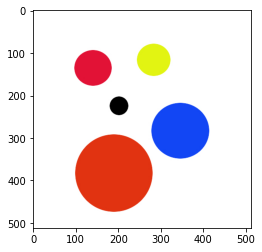

In [3]:
circles = plt.imread("data/circles.jpg")
plt.imshow(circles)
plt.show()

# 1.Image Cropping

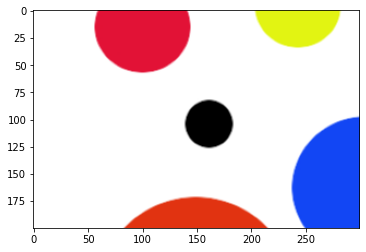

In [4]:
patch = (300, 200)
center = (190, 220)
cropped_image = cv2.getRectSubPix(circles, patch, center)
plt.imshow(cropped_image)
plt.show()

### crop function

In [5]:
def crop(img, center, width, height):
    return cv2.getRectSubPix(img, (width, height), center)

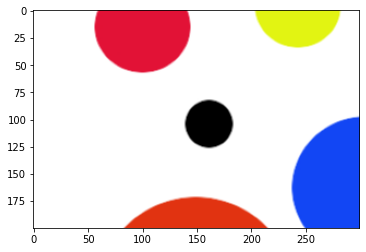

In [6]:
cropped = crop(circles, center=(190, 220), width=300, height=200)
plt.imshow(cropped)
plt.show()

# **2. Rotation-cv2.warpAffine**
- get the transform matrix with `cv2.getRotationMatrix2D`
- params to `cv2.getRotationMatrix2D`: center, angle(+ -> counterclockwise), scale

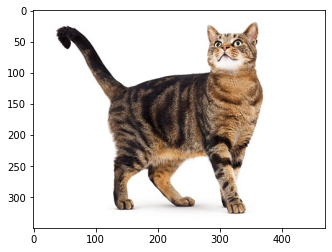

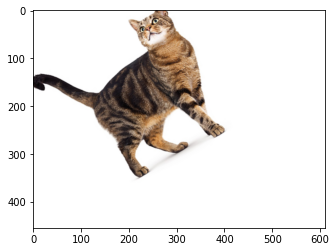

In [7]:
cat = cv2.imread("data/cat.jpg")[:, :, ::-1]
center = cat.shape[1]/2, cat.shape[0]/2
angle = 30
scale = 1.0

M = cv2.getRotationMatrix2D(center, angle, scale)
rotated_cat = cv2.warpAffine(cat, M, (int(cat.shape[1]*1.3), int(cat.shape[0]*1.3)), borderValue=(255, 255, 255))
plt.imshow(cat)
plt.figure()
plt.imshow(rotated_cat)

### rotation function

In [8]:
def rotate(image, angle, border_color=None):
    # grab the dimensions of the image and then determine the
    # center
    if border_color == None:
        border_color=(255, 255, 255)

    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderValue=border_color)

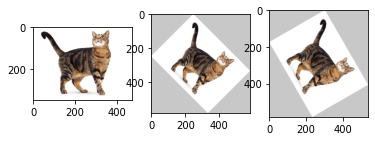

In [9]:
rotated_image1 = rotate(cat, angle=45, border_color = (200, 200, 200))
rotated_image2 = rotate(cat, angle=60, border_color = (200, 200, 200))

fig = plt.figure()
plt.subplot(131)
plt.imshow(cat)
plt.subplot(132)
plt.imshow(rotated_image1)
plt.subplot(133)
plt.imshow(rotated_image2)


# **3. Translation - cv.warpAffine**
- params: img, transMatrix, dsize (dest image size)
- transMatrix M should always be np.asarray([[1., 0., tx], [0., 1., ty]]), where tx and ty are offset on x and y (-x -> left, -y -> up). And it must be a float matrix
- dsize should most of time be (src_img.shape[1], src_img.shape[0]), which are WIDTH and HEIGHT of images (in image domain instead of ndarray domain)

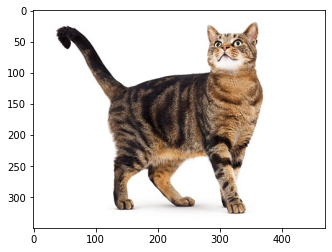

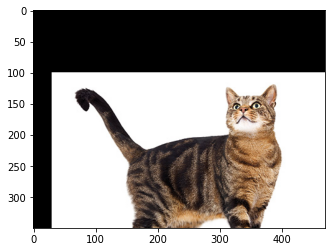

In [10]:
cat = cv2.imread("data/cat.jpg")[:, :, ::-1]
shifted_cat = cv2.warpAffine(cat, 
               np.array([[1, 0, 30], 
                        [0, 1, 100]], 
                dtype = np.float),
               dsize = (cat.shape[1], cat.shape[0])) # right down shift

plt.imshow(cat)
plt.figure()
plt.imshow(shifted_cat)

### translation function

In [11]:
def translate(img, x, y, border_size=None, border_color=None):
    if border_size == None:
        border_size = (img.shape[1], img.shape[0])
    if border_color == None:
        border_color=(255, 255, 255)
   # return return cv2.warpAffine(img, np.array([[1, 0, x], [0, 1, y]]), border_size, borderValue=border_color)
    return cv2.warpAffine(cat, 
               np.array([[1, 0, x], 
                        [0, 1, y]], 
                dtype = np.float),
               border_size, borderValue=border_color) # right down shift

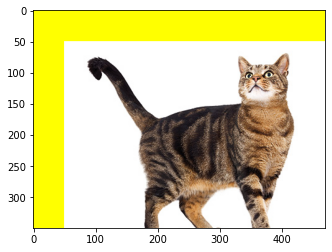

In [12]:
new = translate(cat, 50, 50, border_color=(255, 255, 0))
plt.imshow(new)
plt.show()

# **4. Resizing - cv2.resize**
- it is aspect-ratio (width/height) constant resize 
- params to cv2.resize: img, (with, height) of dest, interpolation_method, cv2.INTER_XX, e.g., cv2.INTER_AREA
- you can also do it via rotation and warpAffine, but the effects are very different - in terms of the dimension of the resulted arrays

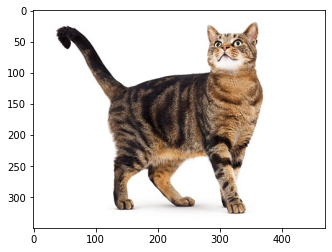

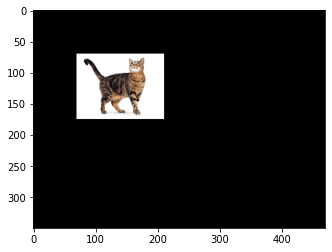

In [13]:
cat = cv2.imread("data/cat.jpg")[:, :, ::-1]
center = (100, 100)
M = cv2.getRotationMatrix2D(center, 0, 0.3)
resized_cat = cv2.warpAffine(cat, M, (cat.shape[1], cat.shape[0]))
plt.imshow(cat)
plt.figure()
plt.imshow(resized_cat)

In [14]:
def bordered_resize(img, scale, center=None, border_size=None, border_color=None):
    if center == None:
        center = (int(img.shape[1]), int(img.shape[0]))
    if border_size == None:
        border_size = (img.shape[1], img.shape[0])
    if border_color == None:
        border_color=(255, 255, 255)
    M = cv2.getRotationMatrix2D(center, 0, scale)
    return cv2.warpAffine(img, M, border_size, borderValue=border_color)

(105, 141, 3)


False

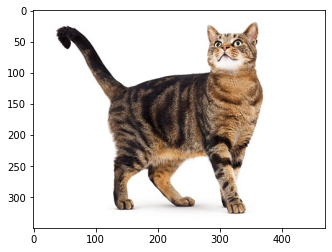

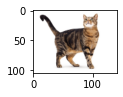

In [15]:
cat = cv2.imread("data/cat.jpg")[:, :, ::-1]
width, height = int(cat.shape[1]*0.3), int(cat.shape[0]*0.3)
resized_cat = cv2.resize(cat, 
                          (width, height), 
                          interpolation = cv2.INTER_AREA,)
plt.imshow(cat)
plt.figure(figsize = (1.5, 1.5))
plt.imshow(resized_cat)
print(resized_cat.shape)

cv2.imwrite("data/images/small_cat.jpg", resized_cat)

In [16]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

# **5. Flipping**

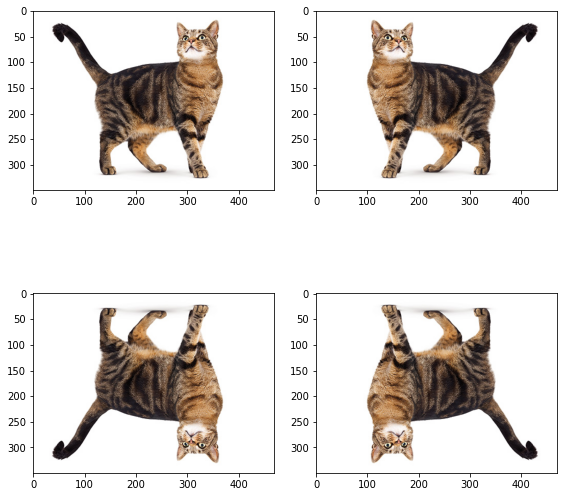

In [17]:
cat = cv2.imread("data/cat.jpg")[:, :, ::-1]
fig, axes = plt.subplots(2, 2, figsize = (8, 8))

fig.tight_layout()

axes = axes.ravel()
axes[0].imshow(cat)
axes[1].imshow(cat[:, ::-1, :])
axes[2].imshow(cat[::-1, :, :])
axes[3].imshow(cat[::-1, ::-1, :])

# 6. Affine transform

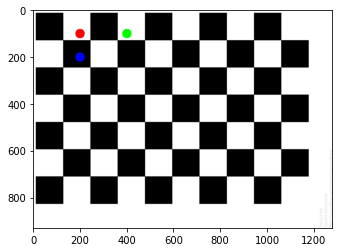

In [20]:
#-*- coding:utf-8 -*-
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('data/chessboard.jpg')
rows, cols, ch = img.shape

# pts1의 좌표에 표시. Affine 변환 후 이동 점 확인.
cv2.circle(img, (200,100), 20, (255,0,0),-1)
cv2.circle(img, (400,100), 20, (0,255,0),-1)
cv2.circle(img, (200,200), 20, (0,0,255),-1)
plt.imshow(img)
plt.show()

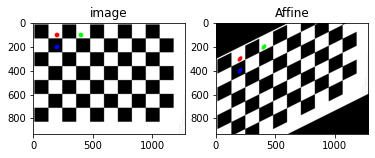

In [21]:
pts1 = np.float32([[200,100],[400,100],[200,200]])
pts2 = np.float32([[200,300],[400,200],[200,400]])

M = cv2.getAffineTransform(pts1, pts2) #pts1 => pts2

dst = cv2.warpAffine(img, M, (cols,rows))

plt.subplot(121),plt.imshow(img),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Affine')
plt.show()

# 7. Perspective Transformation

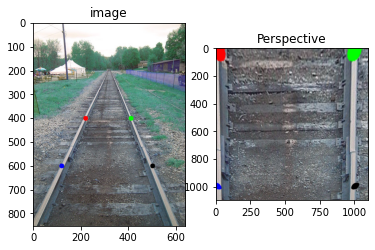

In [19]:
#-*- coding:utf-8 -*-
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('data/Railroad-Tracks-Perspective.jpg')
# [x,y] 좌표점을 4x2의 행렬로 작성
# 좌표점은 좌상->좌하->우상->우하

# pts1의 좌표에 표시. perspective 변환 후 이동 점 확인.
cv2.circle(img, (220,400), 10, (255,0,0),-1)
cv2.circle(img, (410,400), 10, (0,255,0),-1)
cv2.circle(img, (120,600), 10, (0,0,255),-1)
cv2.circle(img, (500,600), 10, (0,0,0),-1)

pts1 = np.float32([[220,400],[120,600],[410,400],[500,600]])

# 좌표의 이동점
pts2 = np.float32([[10,10],[10,1000],[1000,10],[1000,1000]])

M = cv2.getPerspectiveTransform(pts1, pts2)

dst = cv2.warpPerspective(img, M, (1100,1100))

plt.subplot(121),plt.imshow(img),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Perspective')
plt.show()

# 8. Padding

In [ ]:
img = cv2.imread('data/beach.jpg')[:,:,::-1]
bordersize = 100
color = [255, 255, 255]
bordered_img=cv2.copyMakeBorder(img, 
                                top=bordersize,bottom=bordersize, 
                                left=bordersize, right=bordersize, 
                                borderType= cv2.BORDER_CONSTANT, 
                                value=color )

In [ ]:
#cv2.circle(bordered_img, (300, 320), radius = 10, color = [255, 0 ,0])
plt.imshow(bordered_img)
plt.show()

In [ ]:
## RGB images - BGR to RGB
beach = cv2.imread("data/beach.jpg")[:,:,::-1]
plt.imshow(beach)

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

BLUE = (0,0,255)

img1 = beach ## no need to explicitly copy

replicate = cv2.copyMakeBorder(img1,100,100,100,100,cv2.BORDER_REPLICATE)
reflect = cv2.copyMakeBorder(img1,100,100,100,100,cv2.BORDER_REFLECT)
reflect101 = cv2.copyMakeBorder(img1,100,100,100,100,cv2.BORDER_REFLECT_101)
wrap = cv2.copyMakeBorder(img1,100,100,100,100,cv2.BORDER_WRAP)
constant= cv2.copyMakeBorder(img1,100,100,100,100,cv2.BORDER_CONSTANT,value=BLUE)

plt.subplot(231),plt.imshow(img1,'gray'),plt.title('ORIGINAL')
plt.subplot(232),plt.imshow(replicate,'gray'),plt.title('REPLICATE')
plt.subplot(233),plt.imshow(reflect,'gray'),plt.title('REFLECT')
plt.subplot(234),plt.imshow(reflect101,'gray'),plt.title('REFLECT_101')
plt.subplot(235),plt.imshow(wrap,'gray'),plt.title('WRAP')
plt.subplot(236),plt.imshow(constant,'gray'),plt.title('CONSTANT')

# ***9. Split Color Channels***
- using cv2.split and cv2.merge needs to stick with (BGR) channel encoding, which might be more troublesome

In [ ]:
wave = cv2.imread("data/circles.jpg")[:,:,::-1]
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes = axes.ravel()

fig.tight_layout()
axes[0].imshow(wave)
axes[0].set_title("original")
axes[1].imshow(wave[:, :, 0], cmap = plt.cm.gray)
axes[1].set_title("red")
axes[2].imshow(wave[:, :, 1], cmap = plt.cm.gray)
axes[2].set_title("green")
axes[3].imshow(wave[:, :, 2], cmap = plt.cm.gray)
axes[3].set_title("blue")